Visualize Plant Trait Distribution before and after pre-processing

Modified from HDJOJO's original notebook with SWIN Transformer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import timm
import glob
import torchmetrics
import time
import psutil
import os

tqdm.pandas()

In [2]:
class Config():
    IMAGE_SIZE = 256 #384 # Sample: [224, 224]
#     BACKBONE = 'swin_large_patch4_window12_384.ms_in22k_ft_in1k'
    BACKBONE = 'swinv2_tiny_window16_256'
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 10 # Sample: 96
    LR_MAX = 1e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 12 #6
    TRAIN_MODEL = True
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    
    DEVICE = "cuda"
    
    # Added variables
    NUM_FOLDS = 5
    VALID_FOLD = 0  # Fold of validation data
        
CONFIG = Config()

In [3]:
# Read in training data
train_df = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
train_df['file_path'] = train_df['id'].apply(lambda s: f'/kaggle/input/planttraits2024/train_images/{s}.jpeg')
train_df['jpeg_bytes'] = train_df['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
train_df.to_pickle('train.pkl') # serialize object into string form

  0%|          | 0/55489 [00:00<?, ?it/s]

### "Before" Distribution

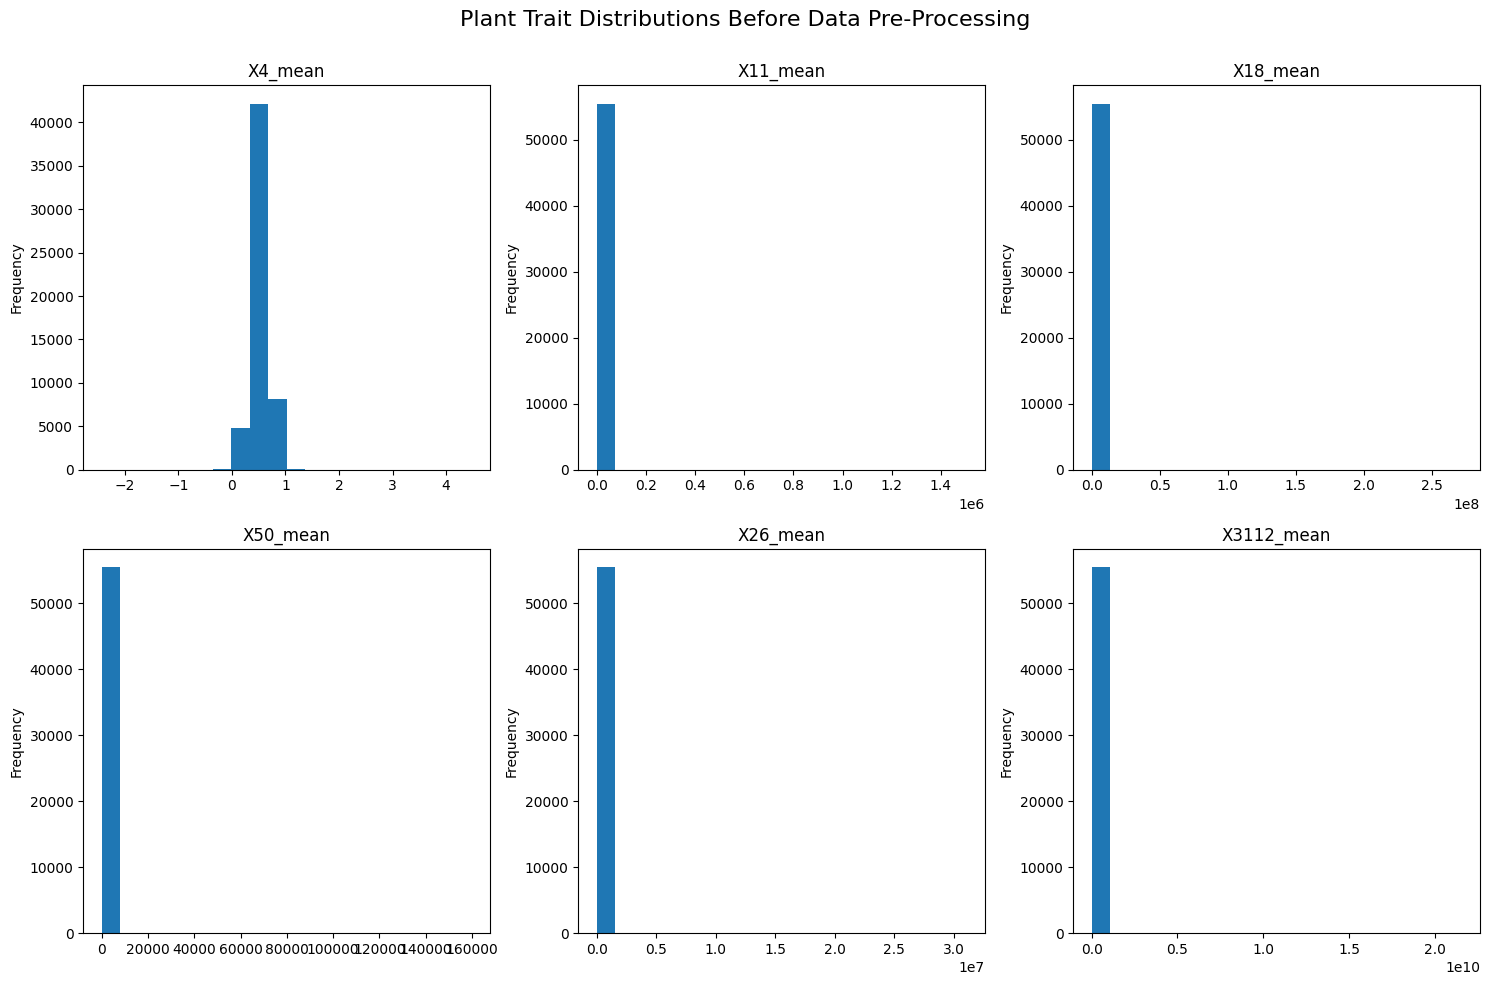

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for i, column in enumerate(CONFIG.TARGET_COLUMNS):
    ax = axes[i // 3, i % 3]
    train_df[column].plot(kind='hist', bins=20, ax=ax, title=column)
fig.suptitle("Plant Trait Distributions Before Data Pre-Processing\n", fontsize=16)
plt.tight_layout()
plt.show()
# fig.savefig('dist_before_preprocess.png')

### Data Filtering

In [22]:
# Sampled training set for faster training
print("Previous length:", len(train_df))

Previous length: 55489


In [23]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CONFIG.NUM_FOLDS, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CONFIG.TARGET_COLUMNS):
    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, CONFIG.NUM_FOLDS + 1))
    train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# Concatenate the bins into a final bin
train_df["final_bin"] = (
    train_df[[f"bin_{i}" for i in range(CONFIG.N_TARGETS)]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
train_df = train_df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
    train_df.loc[valid_idx, "fold"] = fold
    
train_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,file_path,jpeg_bytes,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,final_bin,fold
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,/kaggle/input/planttraits2024/train_images/192...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2,2,1,4,2,1,221421,2.0
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3,3,2,2,2,3,332223,1.0
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,/kaggle/input/planttraits2024/train_images/196...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,5,1,5,5,2,3,515523,0.0
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3,2,3,2,1,3,323213,4.0
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,/kaggle/input/planttraits2024/train_images/195...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2,3,3,5,4,4,233544,2.0


In [33]:
train = train_df[train_df["fold"] != CONFIG.VALID_FOLD]
valid = train_df[train_df["fold"] == CONFIG.VALID_FOLD] # Fold 0 is validation
train[CONFIG.TARGET_COLUMNS + ["fold"]].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean,fold
count,44391.000000,4.439100e+04,4.439100e+04,44391.000000,4.439100e+04,4.439100e+04,44391.000000
mean,0.522456,1.271709e+02,2.460040e+04,12.810444,3.096704e+03,4.938293e+05,2.499966
std,0.176001,1.237979e+04,2.582362e+06,1313.424294,2.210436e+05,1.023270e+08,1.118037
min,-2.431157,6.780000e-05,2.330000e-08,0.000097,5.500000e-07,7.690000e-08,1.000000
25%,0.410739,1.063560e+01,3.099867e-01,1.174045,5.595144e-01,2.552807e+02,1.500000
50%,0.509275,1.512003e+01,7.171231e-01,1.480130,2.529542e+00,7.258266e+02,2.000000
75%,0.622427,1.968705e+01,3.574691e+00,1.924787,1.498396e+01,2.158052e+03,3.000000
max,4.475172,1.504254e+06,2.720494e+08,159759.897700,3.106555e+07,2.155911e+10,4.000000


In [45]:
print(len(train))
print(len(valid))

41797
11098


### Train distribution "before"

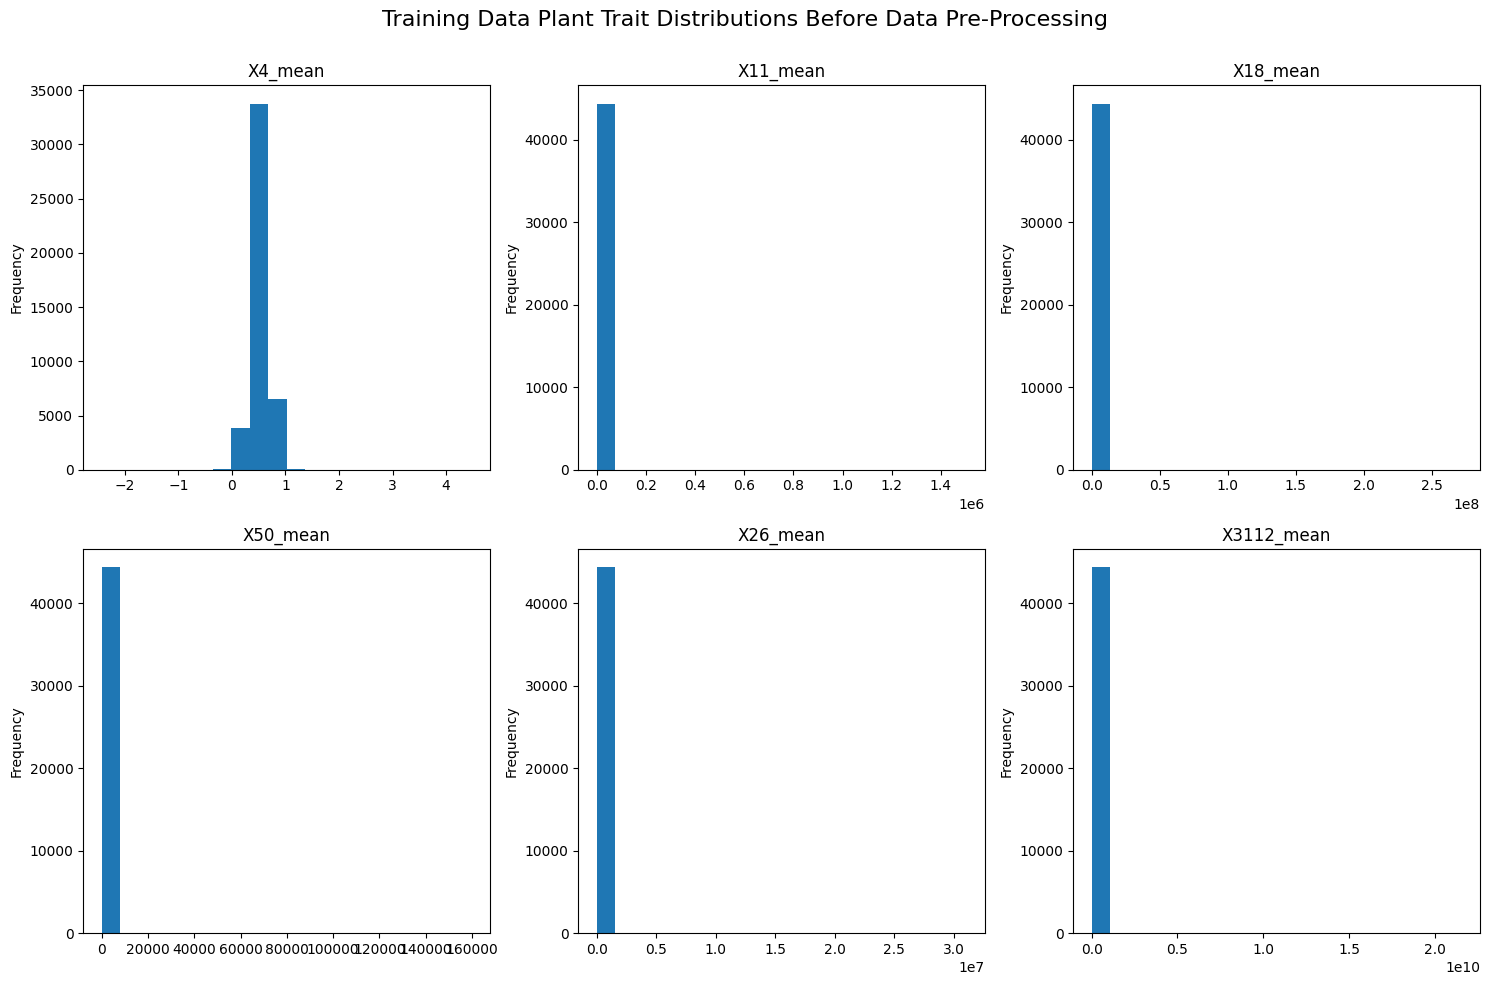

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for i, column in enumerate(CONFIG.TARGET_COLUMNS):
    ax = axes[i // 3, i % 3]
    train[column].plot(kind='hist', bins=20, ax=ax, title=column)
fig.suptitle("Training Data Plant Trait Distributions Before Data Pre-Processing\n", fontsize=16)
plt.tight_layout()
plt.show()
# fig.savefig('train_dist_before_preprocess.png')

In [35]:
class PlantDataPreProcess:
    lower_quantile = 0.005
    upper_quantile = 0.995
    log_transform = np.log10

In [36]:
# Filter data
print("Num samples before filtering:", len(train))

for trait in CONFIG.TARGET_COLUMNS:
    lower_bound = train[trait].quantile(PlantDataPreProcess.lower_quantile)
    upper_bound = train[trait].quantile(PlantDataPreProcess.upper_quantile)
    train = train[(train[trait] >= lower_bound) & (train[trait] <= upper_bound)]
    
print("Num samples After filtering:", len(train))
train[CONFIG.TARGET_COLUMNS].describe()

Num samples before filtering: 44391
Num samples After filtering: 41797


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,41797.000000,41797.000000,41797.000000,41797.000000,41797.000000,41797.000000
mean,0.521676,15.823053,3.207305,1.616637,42.244362,1858.297208
std,0.144273,7.598915,5.347872,0.638061,166.646792,3116.155242
min,0.176725,2.830246,0.032735,0.494166,0.006679,9.725925
25%,0.410757,10.792999,0.318085,1.186312,0.586510,267.237330
50%,0.509045,15.129038,0.714284,1.481727,2.534134,729.941079
75%,0.621267,19.511440,3.402814,1.909787,14.288664,2106.940380
max,0.957788,58.287012,32.388908,4.608223,2369.101479,29876.601410


In [38]:
## Log transforms have been integrated into model itself with selectiveExp layer

# # Log10 transformation for all traits except X4
LOG_FEATURES = ['X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

y_train = train[CONFIG.TARGET_COLUMNS]

for skewed_trait in LOG_FEATURES:
    y_train.loc[:, skewed_trait] = y_train[skewed_trait].apply(PlantDataPreProcess.log_transform)

y_train.describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,41797.000000,41797.000000,41797.000000,41797.000000,41797.000000,41797.000000
mean,0.521676,1.147512,0.002364,0.177637,0.456476,2.853331
std,0.144273,0.221711,0.667655,0.163304,1.036252,0.645715
min,0.176725,0.451824,-1.484983,-0.306127,-2.175279,0.987931
25%,0.410757,1.033142,-0.497456,0.074199,-0.231724,2.426897
50%,0.509045,1.179811,-0.146129,0.170768,0.403830,2.863288
75%,0.621267,1.290289,0.531838,0.280985,1.154992,3.323652
max,0.957788,1.765572,1.510396,0.663534,3.374584,4.475331


In [39]:
# Normalize to mean = 0, std dev = 1
from sklearn.preprocessing import StandardScaler

SCALER = StandardScaler()
y_train = SCALER.fit_transform(y_train)

y_train_df = pd.DataFrame(y_train, columns=CONFIG.TARGET_COLUMNS)
y_train_df.describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,4.179700e+04,4.179700e+04,4.179700e+04,4.179700e+04,4.179700e+04,4.179700e+04
mean,-2.728476e-16,3.077823e-16,8.159928e-18,-1.750985e-17,-2.668976e-17,6.561942e-17
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-2.390994e+00,-3.137852e+00,-2.227742e+00,-2.962396e+00,-2.539718e+00,-2.888924e+00
25%,-7.688273e-01,-5.158568e-01,-7.486282e-01,-6.334180e-01,-6.641329e-01,-6.604133e-01
50%,-8.755138e-02,1.456847e-01,-2.224117e-01,-4.206462e-02,-5.080546e-02,1.541993e-02
75%,6.903019e-01,6.439883e-01,7.930455e-01,6.328630e-01,6.740871e-01,7.283811e-01
max,3.022865e+00,2.787718e+00,2.258726e+00,2.975450e+00,2.816056e+00,2.511973e+00


### Train "After" Distribution

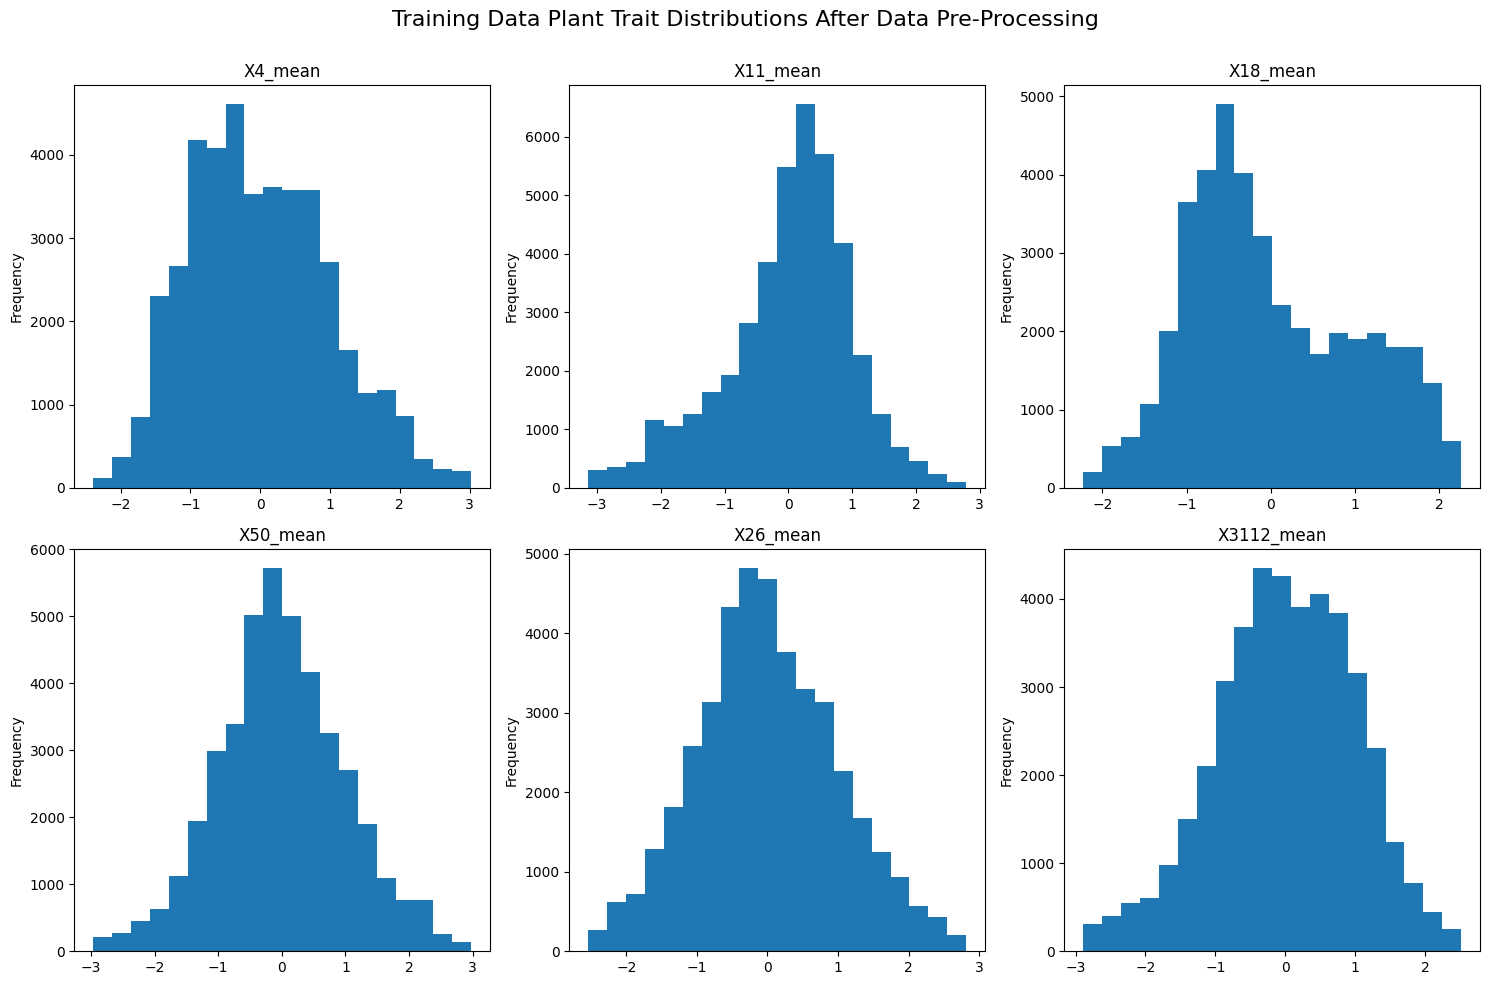

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for i, column in enumerate(CONFIG.TARGET_COLUMNS):
    ax = axes[i // 3, i % 3]
    y_train_df[column].plot(kind='hist', bins=20, ax=ax, title=column)
fig.suptitle("sk\n", fontsize=16)
plt.tight_layout()
plt.show()
# fig.savefig('train_dist_after_preprocess.png')